In [2]:
import numpy as np
import sys
import cv2
from matplotlib import pyplot as plt
import math
from math import sin,cos,radians

#Move to parent folder
sys.path.insert(0, '../croprows-cli/src/')

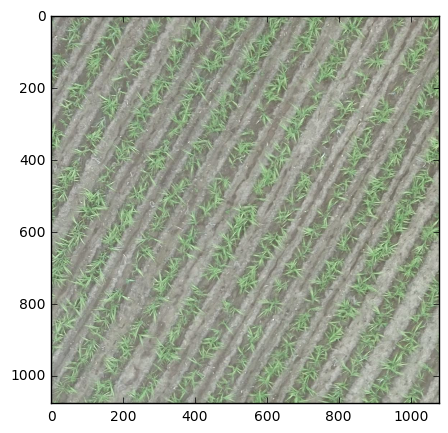

In [3]:
img_read = cv2.imread("../orthomosaics/results/testfile3/mosaic_5_5_1077px_25_tiles/mosaic-cl_3-rw_2.jpg")
plt.figure(figsize=(5, 5))
plt.imshow(img_read)
plt.show()

In [4]:
def calc_ExG(image_in):
    B,G,R = cv2.split(image_in)
    R_ = R/255
    G_ = G/255
    B_ = B/255
    r= R_/(R_+G_+B_)
    g= G_/(R_+G_+B_)
    b= B_/(R_+G_+B_)
    return (2*g - r - b)

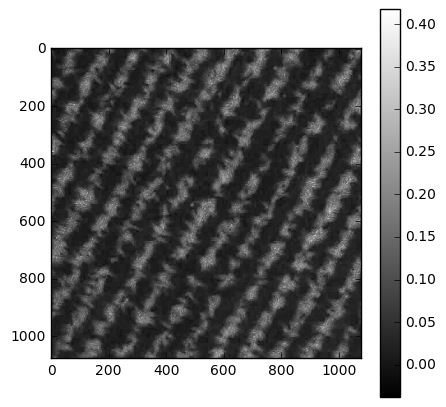

In [5]:
cexg = calc_ExG(img_read)
plt.figure(figsize=(5, 5))
plt.imshow(cexg,cmap=plt.get_cmap('gray'))
plt.colorbar()
plt.show()

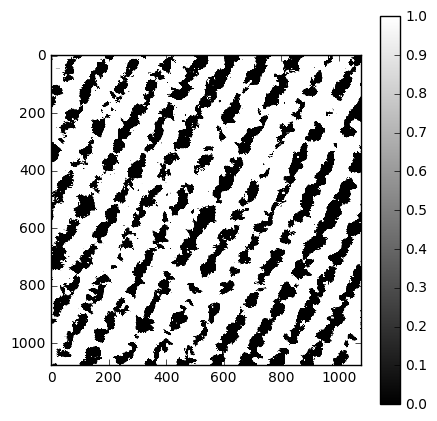

In [6]:
arr = np.uint8(cexg*255)
ret, thres1 =cv2.threshold(arr, 0, 1, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
#cv2.threshold(arr, 0, 1, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

plt.figure(figsize=(5, 5))
plt.imshow(thres1,cmap=plt.get_cmap('gray'))
plt.colorbar()
plt.show()

In [7]:
def rotateImage(image, angle):
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return result

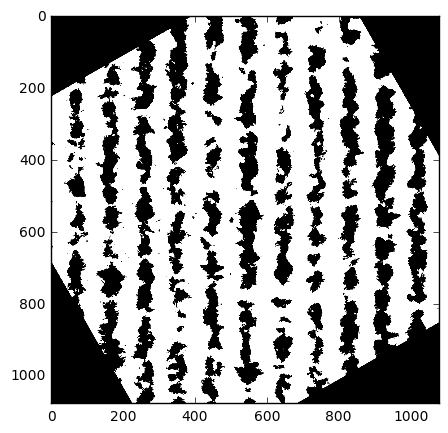

In [8]:
rotate = rotateImage(thres1,(0.53*np.pi*180)+90)
plt.figure(figsize=(5, 5))
plt.imshow(rotate,cmap=plt.get_cmap('gray'))
plt.show()

In [9]:
def rotate_image(image, angle):
    """
    Rotates an OpenCV 2 / NumPy image about it's centre by the given angle
    (in degrees). The returned image will be large enough to hold the entire
    new image, with a black background
    """

    # Get the image size
    # No that's not an error - NumPy stores image matricies backwards
    image_size = (image.shape[1], image.shape[0])
    image_center = tuple(np.array(image_size) / 2)

    # Convert the OpenCV 3x2 rotation matrix to 3x3
    rot_mat = np.vstack(
        [cv2.getRotationMatrix2D(image_center, angle, 1.0), [0, 0, 1]]
    )

    rot_mat_notranslate = np.matrix(rot_mat[0:2, 0:2])

    # Shorthand for below calcs
    image_w2 = image_size[0] * 0.5
    image_h2 = image_size[1] * 0.5

    # Obtain the rotated coordinates of the image corners
    rotated_coords = [
        (np.array([-image_w2,  image_h2]) * rot_mat_notranslate).A[0],
        (np.array([ image_w2,  image_h2]) * rot_mat_notranslate).A[0],
        (np.array([-image_w2, -image_h2]) * rot_mat_notranslate).A[0],
        (np.array([ image_w2, -image_h2]) * rot_mat_notranslate).A[0]
    ]

    # Find the size of the new image
    x_coords = [pt[0] for pt in rotated_coords]
    x_pos = [x for x in x_coords if x > 0]
    x_neg = [x for x in x_coords if x < 0]

    y_coords = [pt[1] for pt in rotated_coords]
    y_pos = [y for y in y_coords if y > 0]
    y_neg = [y for y in y_coords if y < 0]

    right_bound = max(x_pos)
    left_bound = min(x_neg)
    top_bound = max(y_pos)
    bot_bound = min(y_neg)

    new_w = int(abs(right_bound - left_bound))
    new_h = int(abs(top_bound - bot_bound))

    # We require a translation matrix to keep the image centred
    trans_mat = np.matrix([
        [1, 0, int(new_w * 0.5 - image_w2)],
        [0, 1, int(new_h * 0.5 - image_h2)],
        [0, 0, 1]
    ])

    # Compute the tranform for the combined rotation and translation
    affine_mat = (np.matrix(trans_mat) * np.matrix(rot_mat))[0:2, :]

    # Apply the transform
    result = cv2.warpAffine(
        image,
        affine_mat,
        (new_w, new_h),
        flags=cv2.INTER_LINEAR
    )

    return result


def largest_rotated_rect(w, h, angle):
    """
    Given a rectangle of size wxh that has been rotated by 'angle' (in
    radians), computes the width and height of the largest possible
    axis-aligned rectangle within the rotated rectangle.

    Original JS code by 'Andri' and Magnus Hoff from Stack Overflow

    Converted to Python by Aaron Snoswell
    """

    quadrant = int(math.floor(angle / (math.pi / 2))) & 3
    sign_alpha = angle if ((quadrant & 1) == 0) else math.pi - angle
    alpha = (sign_alpha % math.pi + math.pi) % math.pi

    bb_w = w * math.cos(alpha) + h * math.sin(alpha)
    bb_h = w * math.sin(alpha) + h * math.cos(alpha)

    gamma = math.atan2(bb_w, bb_w) if (w < h) else math.atan2(bb_w, bb_w)

    delta = math.pi - alpha - gamma

    length = h if (w < h) else w

    d = length * math.cos(alpha)
    a = d * math.sin(alpha) / math.sin(delta)

    y = a * math.cos(gamma)
    x = y * math.tan(gamma)

    return (
        bb_w - 2 * x,
        bb_h - 2 * y
    )


def crop_around_center(image, width, height):
    """
    Given a NumPy / OpenCV 2 image, crops it to the given width and height,
    around it's centre point
    """

    image_size = (image.shape[1], image.shape[0])
    image_center = (int(image_size[0] * 0.5), int(image_size[1] * 0.5))

    if(width > image_size[0]):
        width = image_size[0]

    if(height > image_size[1]):
        height = image_size[1]

    x1 = int(image_center[0] - width * 0.5)
    x2 = int(image_center[0] + width * 0.5)
    y1 = int(image_center[1] - height * 0.5)
    y2 = int(image_center[1] + height * 0.5)

    return image[y1:y2, x1:x2]


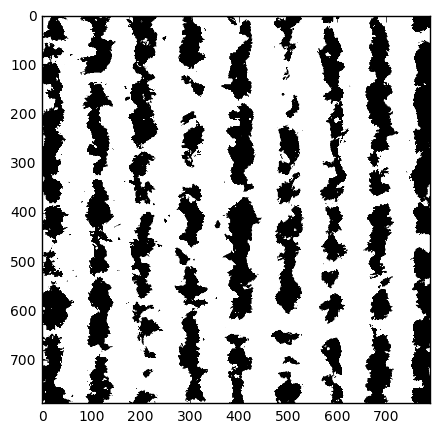

In [10]:
image_orig = np.copy(thres1)
image_height, image_width = image_orig.shape[0:2]

angle = (0.53*np.pi*180)+90

image_rotated = rotate_image(image_orig, angle)
image_rotated_cropped = crop_around_center(
            image_rotated,
            *largest_rotated_rect(
                image_width,
                image_height,
                math.radians(angle)
            )
        )
        

plt.figure(figsize=(5, 5))
plt.imshow(image_rotated_cropped,cmap=plt.get_cmap('gray'))
plt.show()